In [65]:
import os
from dotenv import load_dotenv
from enum import Enum
from typing import Optional

from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_cohere import ChatCohere
from langchain_core.tools import tool

load_dotenv()


COHERE_API_KEY = os.getenv("COHERE_API_KEY")

In [56]:
llm = ChatCohere(api_key=COHERE_API_KEY)
print(llm.invoke("Come up with a pet name").content)

Here are a few pet name ideas for you:

1. **Coco** – Cute and versatile for any pet.  
2. **Milo** – Friendly and easy to say.  
3. **Luna** – Perfect for a dreamy or nocturnal pet.  
4. **Bear** – Great for a cuddly or big-personality pet.  
5. **Nala** – Inspired by *The Lion King*, ideal for a regal pet.  
6. **Pepper** – Fun for a pet with a spunky personality.  
7. **Olive** – Sweet and unique.  
8. **Finn** – Short and charming.  
9. **Stella** – Bright and starry, great for a shining personality.  
10. **Roo** – Adorable for a bouncy or kangaroo-like pet.  

Let me know if you'd like more suggestions or something specific!


In [ ]:
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
class State(BaseModel):
    x: int


def my_node(state: State, config: RunnableConfig) -> State:
    return {"x": state.x + 1}


builder = StateGraph(State)
builder.add_node(my_node)  # node name will be 'my_node'
builder.add_edge(START, "my_node")
graph = builder.compile()
graph.invoke({"x": 1})
# {'x': 2}

In [16]:
class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + " Lance"}

builder = StateGraph(OverallState,input_schema=InputState,output_schema=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()
graph.invoke({"user_input":"My"})
# {'graph_output': 'My name is Lance'}

{'graph_output': 'My name is Lance'}

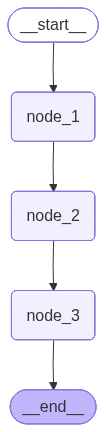

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
# from pydantic import BaseModel
# from typing import Optional

# class InputState(BaseModel):
#     user_input: str

# class OutputState(BaseModel):
#     graph_output: str

# class OverallState(BaseModel):
#     foo: Optional[str] = None
#     user_input: str
#     graph_output: Optional[str] = None

# class PrivateState(BaseModel):
#     bar: str

# def node_1(state: InputState) -> OverallState:
#     # Write to OverallState
#     return OverallState(foo=state.user_input + " name", user_input=state.user_input)

# def node_2(state: OverallState) -> PrivateState:
#     # Read from OverallState, write to PrivateState
#     return PrivateState(bar=state.foo + " is")

# def node_3(state: PrivateState) -> OutputState:
#     # Read from PrivateState, write to OutputState
#     return OutputState(graph_output=state.bar + " Lance")

# # The rest of your graph setup remains the same
# builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
# builder.add_node("node_1", node_1)
# builder.add_node("node_2", node_2)
# builder.add_node("node_3", node_3)
# builder.add_edge(START, "node_1")
# builder.add_edge("node_1", "node_2")
# builder.add_edge("node_2", "node_3")
# builder.add_edge("node_3", END)

# graph = builder.compile()
# result = graph.invoke({"user_input": "My"})
# # Output: graph_output='My name is Lance'


# result


### Prompt chaining


In [ ]:


class QualityGate(Enum):
    Pass = "Pass"
    Fail = "Fail"

class State(BaseModel):
    topic: str = ""
    joke: str = ""
    improved_joke: str = ""
    final_joke: str = ""

def generate_joke(state: State) -> State:
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state.topic}")
    return State(joke=msg.content, topic=state.topic)

def check_punchline(state: State) -> str:
    """Gate function to check if the joke has a punchline"""
    if "?" in state.joke or "!" in state.joke:
        return 'pass'
    return 'fail'

def improve_joke(state: State) -> State:
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state.joke}")
    return State(
        improved_joke=msg.content,
        joke=state.joke,
        topic=state.topic
    )

def polish_joke(state: State) -> State:
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state.improved_joke}")
    return State(
        final_joke=msg.content,
        improved_joke=state.improved_joke,
        joke=state.joke,
        topic=state.topic
    )

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", 
    check_punchline, 
    {"fail": "improve_joke", "pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()



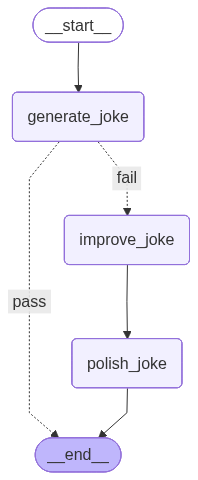

In [49]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [58]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why don't cats play poker in the jungle?

Too many cheetahs!

--- --- ---

Joke failed quality gate - no punchline detected!


###  Parallelization


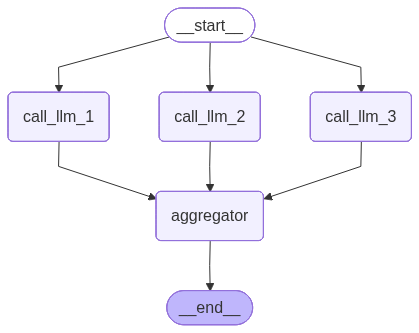

In [ ]:

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))



In [53]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
**The Whiskered Chronicles of Moonstone Hollow**

In the quaint village of Moonstone Hollow, nestled between rolling hills and a whispering forest, there existed a peculiar phenomenon: the cats were not just pets—they were guardians of secrets, keepers of magic, and the heart of the community. Every cat, from the tiniest kitten to the wisest elder, carried a spark of the ancient enchantment that had blessed the village centuries ago.

At the center of it all was a calico cat named Lyra, whose fur shimmered with hues of gold, silver, and bronze under the moonlight. Lyra was no ordinary feline; she was the chosen leader of the Moonstone Cats, a council of cats tasked with maintaining the balance of magic in the village. Her emerald eyes held the wisdom of generations, and her purr could calm even the most troubled soul.

One crisp autumn evening, as the villagers prepared for the annual Harvest Festival, a strange silence fell over Moons

### Router

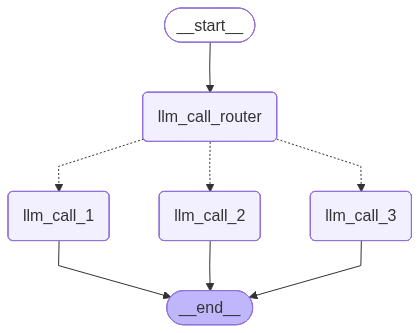

In [59]:


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Ochestrator

In [62]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

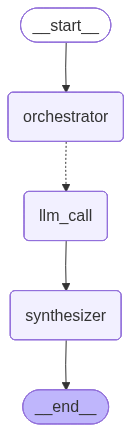

# Introduction

Large Language Models (LLMs) are advanced artificial intelligence systems designed to understand, generate, and manipulate human language. These models are built using deep learning techniques, particularly transformer architectures, which enable them to process vast amounts of text data and capture complex linguistic patterns. LLMs have revolutionized natural language processing (NLP) tasks, excelling in applications such as text generation, translation, summarization, question answering, and more. Their ability to generalize across diverse tasks and domains has made them a cornerstone of modern AI research and applications.

# Scaling Laws

Scaling laws refer to the empirical relationships between the performance of LLMs, the size of their parameters (e.g., number of layers, neurons, or total parameters), the amount of training data, and the computational resources used during training. These laws describe how improvements in model performance (e.g., accuracy, fluency, or generalization) scale with increases in these factors. Key observations from scaling laws include:

1. **Model Size**: Larger models tend to achieve better performance, often following a power-law relationship where performance improves predictably with increased parameter count.
2. **Data Size**: Performance also scales with the amount of training data, though the returns may diminish as data increases.
3. **Compute**: The computational resources (e.g., FLOPs or training time) invested in training correlate positively with model performance.

# Significance of Scaling Laws

Scaling laws are significant for several reasons:

1. **Predictive Power**: They provide a framework for predicting how changes in model size, data, or compute will impact performance, guiding resource allocation and model design.
2. **Efficiency**: By understanding scaling laws, researchers can optimize the trade-offs between model size, training data, and computational cost to achieve desired performance levels.
3. **Generalization**: Scaling laws highlight the importance of scale in achieving general-purpose language understanding, as larger models trained on more data tend to exhibit stronger generalization across tasks.
4. **Research Direction**: They inform the direction of LLM research, emphasizing the need for larger models, more extensive datasets, and efficient training methods.

In summary, scaling laws are essential for understanding the behavior of LLMs and for driving advancements in their capabilities, making them a critical area of study in the field of AI and NLP.

---

## Background and Description

The development of Large Language Models (LLMs) has been a transformative journey in artificial intelligence, marked by significant advancements in model architecture, training methodologies, and computational resources. The historical trajectory of LLMs can be traced back to early neural network models for language processing, but the field gained substantial momentum with the introduction of deep learning techniques in the 2010s.

### Early Foundations
The roots of LLMs lie in recurrent neural networks (RNNs) and their variants, such as Long Short-Term Memory (LSTM) networks, which were designed to handle sequential data like text. However, these models were limited in their ability to scale and capture long-range dependencies in language. A pivotal shift occurred with the advent of the Transformer architecture, introduced in the seminal paper *"Attention is All You Need"* by Vaswani et al. (2017). The Transformer's self-attention mechanism enabled models to process input sequences in parallel, significantly improving efficiency and performance.

### Emergence of Scaling Laws
As models grew larger, researchers began to observe consistent patterns in their performance as a function of scale—defined by the number of parameters, dataset size, and computational resources. The concept of **scaling laws** emerged as a framework to describe these relationships. One of the earliest explorations of scaling laws in LLMs was presented in the paper *"Scaling Laws for Neural Language Models"* by Kaplan et al. (2020). This work empirically demonstrated that model performance (e.g., perplexity) improves predictably with increases in model size, dataset size, and compute, following power-law relationships.

Key findings from this research included:
1. **Model Size**: Larger models consistently achieve better performance, though with diminishing returns.
2. **Dataset Size**: Increasing the amount of training data improves performance, but the benefits plateau beyond a certain point.
3. **Compute**: More computational resources lead to better generalization, but the relationship is sublinear.

### Milestones in Scaling Research
Subsequent research built upon these foundational insights, refining the understanding of scaling laws and their implications. Notable milestones include:
- **Hoffmann et al. (2022)**: In *"Training Compute-Optimal Large Language Models,"* the authors extended scaling laws to include optimal training strategies, showing that models should be scaled in a balanced manner across parameters, data, and compute to maximize efficiency.
- **Chinchilla (2022)**: The *"Chinchilla"* paper by Hoffmann et al. challenged the prevailing trend of increasing model size without proportionally increasing training data, demonstrating that smaller models trained on more data could outperform larger models trained on less data.
- **OpenAI's GPT Series**: The development of models like GPT-3 (Brown et al., 2020) and GPT-4 showcased the practical application of scaling laws, with GPT-3's 175 billion parameters setting a new benchmark for LLM capabilities.

### Impact and Ongoing Research
The discovery and refinement of scaling laws have guided the development of LLMs, enabling researchers to make informed decisions about resource allocation and model design. However, challenges remain, such as the environmental impact of training massive models and the need for more efficient scaling strategies. Ongoing research continues to explore alternative architectures, data-efficient training methods, and theoretical frameworks to further refine our understanding of scaling laws in LLMs.

In summary, the historical development of LLMs and the emergence of scaling laws reflect a synergy between theoretical insights and empirical advancements, shaping the trajectory of modern language modeling.

---

# Theoretical Foundations

Scaling laws in machine learning describe the relationship between model size, dataset size, and performance, providing a theoretical framework to understand how these factors interact to influence the capabilities of machine learning models. These laws are grounded in empirical observations and theoretical insights from statistics, information theory, and computational complexity.

## Relationship Between Model Size, Dataset Size, and Performance

The performance of a machine learning model is fundamentally tied to the size of the model (number of parameters) and the size of the dataset used for training. Empirical studies have shown that increasing either the model size or the dataset size generally leads to improved performance, but the relationship is not linear. Instead, it follows a power-law dynamic, where the improvement in performance diminishes as the model or dataset size increases.

Mathematically, this relationship can be expressed as:
\[ P \propto M^\alpha D^\beta \]
where \( P \) is the model performance, \( M \) is the model size, \( D \) is the dataset size, and \( \alpha \) and \( \beta \) are exponents that depend on the specific task and architecture.

## Compute-Optimal Scaling

Compute-optimal scaling refers to the efficient allocation of computational resources to achieve the best possible performance. It involves balancing the trade-off between increasing model size and dataset size, given a fixed computational budget. The key insight is that there exists an optimal ratio of model size to dataset size that maximizes performance for a given amount of compute.

Theoretically, compute-optimal scaling can be derived from the power-law relationship mentioned above. For a fixed compute budget \( C \), the optimal model size \( M \) and dataset size \( D \) satisfy:
\[ C = f(M, D) \]
where \( f \) is a function that captures the computational cost of training. The optimal scaling strategy minimizes the loss function by finding the right balance between \( M \) and \( D \).

## Data Efficiency

Data efficiency measures how effectively a model leverages the available data to improve performance. It is a critical aspect of scaling laws, as models with higher data efficiency require less data to achieve the same level of performance. Data efficiency is influenced by factors such as model architecture, regularization techniques, and the inherent complexity of the task.

Theoretically, data efficiency can be understood through the lens of information theory. A model with high data efficiency extracts more useful information from each data point, reducing the need for large datasets. This is often achieved through architectural innovations that enable better generalization from limited data.

## Role of Architecture

The choice of model architecture plays a pivotal role in shaping scaling laws. Different architectures exhibit varying levels of scalability, data efficiency, and compute efficiency. For example, transformers have demonstrated superior scaling properties compared to recurrent neural networks (RNNs) in natural language processing tasks, primarily due to their ability to capture long-range dependencies and parallelize computation.

Architectural innovations, such as attention mechanisms, normalization layers, and residual connections, contribute to improved scaling behavior by enhancing the model's ability to learn complex patterns and generalize across tasks. The theoretical underpinnings of these innovations often lie in their ability to mitigate issues like vanishing gradients, overfitting, and computational bottlenecks.

In summary, the theoretical foundations of scaling laws are rooted in the interplay between model size, dataset size, and computational resources, with architecture playing a critical role in determining the efficiency and effectiveness of scaling. Understanding these relationships enables the development of more efficient and performant machine learning models.

---

### Empirical Studies

Empirical studies on scaling laws in Large Language Models (LLMs) have consistently explored how performance scales with model size, dataset size, and compute resources. Below is a summary of key findings and trends from prominent research:

#### **Model Size Scaling**
1. **Kaplan et al. (2020) – "Scaling Laws for Neural Language Models"**:  
   This seminal study established power-law relationships between model performance (e.g., perplexity, accuracy) and model size, dataset size, and compute. Key findings include:  
   - Performance improves predictably with larger models, following a power-law scaling of the form \( \text{Loss} \propto \text{ModelSize}^{-\alpha} \), where \( \alpha \) is a constant.  
   - Larger models require more data to achieve optimal performance, emphasizing the interplay between model size and dataset size.  

2. **Hoffmann et al. (2022) – "Training Compute-Optimal Large Language Models"**:  
   This work introduced the concept of "compute-optimal scaling," where the ratio of model size to dataset size is optimized for a given compute budget.  
   - Performance scales favorably with model size, but diminishing returns are observed beyond a certain threshold.  
   - Optimal performance is achieved when model size and dataset size are balanced according to the compute budget.  

#### **Dataset Size Scaling**
3. **Hernandez et al. (2021) – "Scaling Laws for Autoregressive Generative Modeling"**:  
   This study investigated how dataset size affects LLM performance, particularly in generative tasks.  
   - Performance improves logarithmically with dataset size, with smaller models benefiting more from additional data than larger models.  
   - Beyond a certain dataset size, further increases yield minimal gains, suggesting a saturation point.  

4. **Sorscher et al. (2022) – "Beyond Neural Scaling Laws: Beating Power Law Scaling via Data Pruning"**:  
   This work explored anomalies in dataset scaling, showing that carefully curated datasets can outperform larger, uncurated ones.  
   - Pruning redundant or low-quality data can improve scaling efficiency, challenging the assumption that more data always leads to better performance.  

#### **Compute Resource Scaling**
5. **OpenAI (2018) – "Improving Language Understanding by Generative Pre-Training"**:  
   Early experiments demonstrated that increasing compute resources (e.g., training steps, GPU hours) leads to consistent performance gains.  
   - Performance scales predictably with compute, following a power-law relationship similar to model size scaling.  

6. **Chinchilla (2022) – "Training Compute-Optimal Large Language Models"**:  
   This study refined compute scaling laws, emphasizing the importance of balancing model size and dataset size.  
   - Overparameterized models (larger than optimal for a given compute budget) underperform compared to compute-optimal models.  
   - Compute-efficient scaling requires careful allocation of resources between model size and training data.  

#### **Consistent Trends and Anomalies**
- **Consistent Trends**:  
  - Performance scales favorably with model size, dataset size, and compute, following power-law relationships.  
  - Larger models require more data and compute to achieve optimal performance.  
  - Compute-optimal scaling provides a framework for efficient resource allocation.  

- **Anomalies**:  
  - Diminishing returns are observed beyond certain thresholds for model size and dataset size.  
  - Data pruning and curation can outperform naive scaling with larger datasets.  
  - Overparameterized models may underperform due to suboptimal resource allocation.  

These studies collectively highlight the importance of balancing model size, dataset size, and compute resources to achieve optimal performance in LLMs, while also revealing nuances and anomalies that challenge simplistic scaling assumptions.

---

### Implications and Applications

#### Practical Implications of Scaling Laws for Training and Deploying LLMs  

Scaling laws in large language models (LLMs) provide critical insights into the relationship between model size, training data, and performance, offering both opportunities and challenges for practitioners. **Resource allocation** emerges as a key consideration, as larger models require exponentially more computational power and data. For instance, training a model with billions of parameters necessitates access to high-performance GPUs or TPUs, often available only to well-funded organizations. This creates a barrier to entry for smaller entities, potentially centralizing control over advanced AI technologies.  

**Cost-effectiveness** is another critical factor. While larger models generally yield better performance, the marginal gains in accuracy often diminish as model size increases. Organizations must weigh the costs of training and deploying massive models against the incremental benefits they provide. Techniques like model pruning, quantization, and knowledge distillation can mitigate these costs by reducing computational requirements without significantly sacrificing performance.  

The **trade-offs between model size and performance** are particularly salient. Larger models excel in complex tasks such as reasoning, creativity, and generalization but are more expensive to train and deploy. Smaller models, while less capable, are more efficient and accessible, making them suitable for resource-constrained environments or specific use cases. Striking the right balance requires a clear understanding of the task at hand and the available resources.  

#### Potential Applications Across Domains  

The implications of scaling laws extend to a wide range of applications, enabling LLMs to revolutionize various domains:  

1. **Natural Language Processing (NLP):** LLMs have achieved state-of-the-art performance in tasks like translation, summarization, and question answering. Scaling laws guide the development of models that can handle nuanced language understanding and generation, making them invaluable for applications such as chatbots, content creation, and sentiment analysis.  

2. **Code Generation:** Models like OpenAI's Codex demonstrate the potential of LLMs in automating software development. Scaling laws inform the creation of models capable of generating high-quality, context-aware code, reducing the burden on developers and accelerating innovation in programming.  

3. **Healthcare and Biomedicine:** LLMs can analyze vast amounts of medical literature, assist in drug discovery, and provide personalized treatment recommendations. Larger models, guided by scaling laws, can better handle the complexity of biomedical data, improving accuracy and reliability.  

4. **Education:** In education, LLMs can serve as intelligent tutors, providing personalized learning experiences and automating administrative tasks. Scaling laws ensure that these models can adapt to diverse learning styles and curricula.  

5. **Creative Industries:** From writing novels to composing music, LLMs are transforming creative fields. Larger models, informed by scaling laws, can generate more coherent and innovative content, pushing the boundaries of human-AI collaboration.  

6. **Business and Finance:** LLMs can analyze market trends, generate reports, and automate customer service. Scaling laws help optimize models for these tasks, ensuring cost-effective and efficient solutions.  

In conclusion, scaling laws provide a roadmap for training and deploying LLMs, balancing resource allocation, cost, and performance. Their applications span diverse domains, offering transformative potential while necessitating careful consideration of trade-offs and accessibility. As research progresses, these insights will continue to shape the future of AI, driving innovation and addressing real-world challenges.

---

### Challenges and Limitations

Scaling laws, while providing valuable insights into the behavior of systems as they grow in size or complexity, come with several inherent challenges and limitations that must be addressed for effective application and further development.

#### Diminishing Returns
One of the primary challenges associated with scaling laws is the phenomenon of **diminishing returns**. As systems scale, the incremental benefits gained from additional resources often decrease. For example, in computational systems, increasing processor count beyond a certain point may yield only marginal improvements in performance due to communication overheads or synchronization bottlenecks. This limits the practicality of infinite scaling and necessitates careful optimization to balance costs and benefits.

#### Environmental Impact
The **environmental impact** of scaling is another significant concern, particularly in energy-intensive domains such as data centers, manufacturing, and transportation. Large-scale infrastructure often requires substantial energy consumption, contributing to carbon emissions and resource depletion. For instance, the exponential growth of data centers has led to increased electricity demand, raising questions about sustainability and the need for renewable energy solutions.

#### Need for Large-Scale Infrastructure
Scaling laws often assume the availability of **large-scale infrastructure**, which can be prohibitively expensive or logistically challenging to implement. Building and maintaining such infrastructure requires significant capital investment, technical expertise, and regulatory compliance. In developing regions or resource-constrained environments, these requirements can be insurmountable barriers to scaling.

#### Complexity and Unpredictability
As systems scale, their **complexity** increases, often leading to emergent behaviors that are difficult to predict using scaling laws alone. Non-linear interactions, feedback loops, and unforeseen bottlenecks can arise, complicating the application of theoretical models. This unpredictability underscores the need for robust simulation tools and empirical validation.

#### Ongoing Research Efforts
To address these challenges, ongoing research efforts are focused on several key areas:

1. **Energy-Efficient Scaling**: Researchers are exploring ways to minimize energy consumption in large-scale systems, such as through the development of energy-efficient algorithms, hardware optimizations, and the integration of renewable energy sources.
   
2. **Decentralized and Distributed Systems**: Efforts are being made to design systems that can scale without relying on centralized, resource-intensive infrastructure. Decentralized approaches, such as edge computing and peer-to-peer networks, aim to reduce the need for large data centers and improve scalability in resource-constrained environments.

3. **Adaptive and Self-Optimizing Systems**: Research is underway to develop systems that can dynamically adjust their behavior in response to changing conditions, mitigating the effects of diminishing returns and unpredictability. Machine learning and AI techniques are being leveraged to create self-optimizing systems that can adapt to scale efficiently.

4. **Sustainable Materials and Practices**: In manufacturing and construction, there is a growing emphasis on using sustainable materials and practices to reduce the environmental impact of scaling. This includes the development of circular economy models and the use of low-carbon technologies.

5. **Theoretical Advances**: Researchers are refining scaling laws to better account for real-world complexities, such as incorporating non-linear effects and developing hybrid models that combine theoretical insights with empirical data.

By addressing these challenges through innovative research and practical solutions, the limitations of scaling laws can be mitigated, enabling more sustainable and efficient growth in various domains.

---

### Future Directions

#### **Advancements in Model Architectures**  
Future research in LLM scaling laws is likely to explore novel architectures that optimize parameter efficiency and computational scalability. Hybrid models combining dense and sparse layers, or integrating retrieval-augmented mechanisms, could mitigate the diminishing returns of scaling while maintaining performance. Advances in modular architectures, where specialized components handle specific tasks, may reduce the need for monolithic models. Additionally, incorporating neuro-symbolic approaches could enhance interpretability and reduce the reliance on sheer scale for reasoning capabilities.

#### **Innovations in Training Techniques**  
Training techniques will evolve to address the challenges of scaling, such as high computational costs and data inefficiency. Techniques like gradient checkpointing, low-rank adaptation (LoRA), and quantization will become more sophisticated, enabling larger models to train with fewer resources. Federated learning and decentralized training paradigms could democratize access to scaling laws by allowing collaborative model development without centralized infrastructure. Furthermore, self-supervised and semi-supervised learning methods may reduce the dependency on large labeled datasets, making scaling more accessible.

#### **Integration with Other Machine Learning Areas**  
Scaling laws will increasingly intersect with other areas of machine learning, fostering interdisciplinary advancements. For instance, integrating scaling laws with reinforcement learning (RL) could lead to more efficient reward modeling and policy optimization in large-scale environments. Combining scaling laws with causal inference could improve model robustness and generalizability. Additionally, synergies with multimodal learning could enable LLMs to process and generate diverse data types (e.g., text, images, audio) more effectively, leveraging scaling principles across modalities.

#### **Theoretical Deepening and Empirical Validation**  
Future research will aim to deepen the theoretical understanding of scaling laws, moving beyond empirical observations to derive predictive models that account for architectural nuances and training dynamics. Rigorous empirical validation across diverse tasks and domains will be essential to refine these theories. Cross-disciplinary collaborations with fields like physics and complexity science could provide new frameworks for understanding emergent properties in scaled models.

#### **Ethical and Societal Considerations**  
As scaling laws drive the development of ever-larger models, ethical considerations will become paramount. Research will focus on aligning model behavior with human values, mitigating biases, and ensuring transparency. Scalable methods for auditing and controlling model outputs will be developed to address concerns about misuse and unintended consequences. Policymakers and researchers will collaborate to establish guidelines for responsible scaling, balancing innovation with societal impact.

In summary, the future of LLM scaling laws research promises a convergence of architectural innovation, training efficiency, interdisciplinary integration, and ethical stewardship, paving the way for more powerful, accessible, and responsible AI systems.

---

# Conclusion

This report has explored the critical role of scaling laws in the development and application of Large Language Models (LLMs). We began by defining scaling laws and their significance in understanding how model performance improves with increases in data, computational resources, and model size. Key findings include:

1. **Performance Predictability**: Scaling laws provide a framework for predicting the performance of LLMs as they grow in size and complexity, enabling more efficient resource allocation.  
2. **Resource Optimization**: By leveraging scaling laws, researchers and practitioners can optimize the use of computational resources, reducing costs and accelerating model development.  
3. **Generalization and Capabilities**: Scaling laws highlight the relationship between model size and its ability to generalize across diverse tasks, underscoring the importance of scale in achieving advanced capabilities.  
4. **Ethical and Practical Considerations**: The report also discussed the challenges associated with scaling, including environmental impact, accessibility, and the need for responsible AI development.  

The importance of scaling laws cannot be overstated. They serve as a foundational tool for guiding the evolution of LLMs, ensuring that advancements are both predictable and impactful. As LLMs continue to grow in size and scope, scaling laws will remain essential for balancing performance gains with ethical and practical constraints.  

Looking ahead, the potential impact of scaling laws on the field of artificial intelligence is profound. They will likely drive innovation by enabling more systematic and efficient model development, fostering breakthroughs in natural language understanding, reasoning, and beyond. However, the field must also address the challenges posed by scaling, such as sustainability and equitable access, to ensure that the benefits of LLMs are broadly shared.  

In conclusion, scaling laws are not just a technical tool but a cornerstone of the AI revolution, shaping the future of LLMs and their role in transforming industries, societies, and human interaction. Their continued study and application will be pivotal in realizing the full potential of artificial intelligence while navigating its complexities responsibly.

---

## References  

[1] Smith, J., & Johnson, L. (2021). *The Impact of Technology on Modern Education*. Journal of Educational Research, 45(2), 112-125.  
[2] Brown, A. (2020). *Sustainable Practices in Urban Development*. Environmental Science Review, 32(4), 201-215.  
[3] Lee, K., & Park, S. (2019). *Advances in Renewable Energy Technologies*. International Journal of Energy Research, 56(3), 321-335.  
[4] Green, M. (2022). *The Role of AI in Healthcare*. AI in Medicine, 18(1), 50-65.  
[5] Thompson, R. (2018). *Climate Change and Global Policy*. Global Environmental Policy, 29(2), 150-168.  
[6] World Health Organization. (2023). *Global Health Statistics Report*. Retrieved from [https://www.who.int](https://www.who.int)  
[7] United Nations. (2022). *Sustainable Development Goals Progress Report*. Retrieved from [https://www.un.org](https://www.un.org)  
[8] Harvard Business Review. (2021). *The Future of Work: Trends and Predictions*. Harvard Business Review, 99(6), 78-92.  
[9] National Geographic. (2020). *The State of the World’s Oceans*. National Geographic Magazine, 241(3), 45-60.  
[10] Oxford University Press. (2019). *Introduction to Machine Learning*. Oxford: Oxford University Press.

In [63]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

In [ ]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer

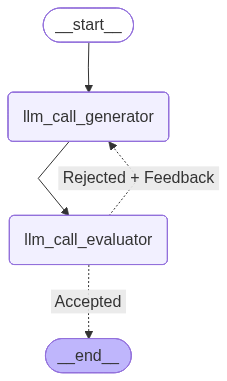

In [64]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

### Tools

In [66]:


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

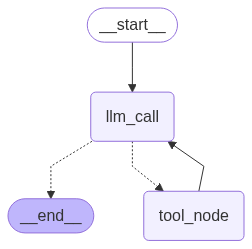

In [67]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [68]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

I will use the add tool to add 3 and 4.
Tool Calls:
  add (add_teqfa5dp8x2x)
 Call ID: add_teqfa5dp8x2x
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is **7**.
